📦 Predicted Bounding Box: [0.50390625, 0.0009765625, 0.0029296875, 0.0029296875]


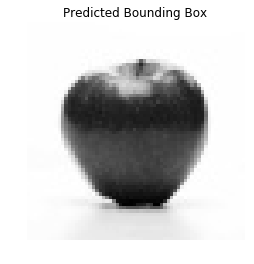

In [10]:
import numpy as np
import cv2
from pynq import Overlay
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- Load FPGA overlay ---
overlay = Overlay("design_1_wrapper.bit")
ip = overlay.object_detect_nnbw_0
scale = 2 ** 10  # Q10 fixed-point scale

# --- Load and preprocess image ---
img_path = "apple3.jpg"  
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")
img_resized = cv2.resize(img, (64, 64)).astype(np.float32) / 255.0
flat = img_resized.flatten()
fixed_input = (flat * scale).astype(np.int16)

# --- Write input to FPGA ---
for i in range(64 * 64):  # 4096 pixels
    ip.write(0x10 + i * 4, int(fixed_input[i]))

# --- Start FPGA IP ---
ip.write(0x00, 0x01)
while (ip.read(0x00) & 0x2) == 0:
    pass

# --- Read output bounding box ---
output = [ip.read(0x100 + i * 4) / scale for i in range(4)]
print("📦 Predicted Bounding Box:", output)

# --- Visualize bounding box on the original image ---
x = int(output[0] * img.shape[1])
y = int(output[1] * img.shape[0])
w = int(output[2] * img.shape[1])
h = int(output[3] * img.shape[0])

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
plt.title("Predicted Bounding Box")
plt.axis('off')
plt.show()
